### Cuda Launch blocking
**`%env CUDA_LAUNCH_BLOCKING=1`** 
sets a variable that makes CUDA GPU operations run sequentially/synchronously in Jupyter notebooks for simplicity, despite reducing parallel performance.

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

In [ ]:
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image

### Set random seeds for the entire session.

In [ ]:
random.seed(17)
np.random.seed(17)
torch.manual_seed(17)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
!git clone https://github.com/ActiveVisionLab/nerfmm.git

### Import general NeRF-related functions, including:

- positional encoding
- volume sampling
- volume rendering
- ray direction computing



In [ ]:
from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy

# utlities
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4


### Importing our datasets

In [ ]:
custom_dataset_name = 'Dataset_7'
dataset_folder = 'Datasets/RGB'  
scene_name = 'Blender_Data' 
image_dir = os.path.join(dataset_folder, custom_dataset_name)

# Count the number of images in the dataset folder
num_images = len([f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')])

print('Selected custom dataset: "{}"'.format(custom_dataset_name))
print('Dataset path: {}'.format(image_dir))
print('Number of images in the dataset: {}'.format(num_images))

#### Installing `Imageio`

In [ ]:
pip install imageio

### Load Images

In [ ]:
import imageio 
def load_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    N_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint8
        img_list.append(img)
    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    results = {
        'imgs': img_list,  # (N, H, W, 3) torch.float32
        'img_names': img_names,  # (N, )
        'N_imgs': N_imgs,
        'H': H,
        'W': W,
    }
    return results

image_data = load_imgs(image_dir)
imgs = image_data['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = image_data['N_imgs']
H = image_data['H']
W = image_data['W']

print('Loaded {0} imgs, resolution {1} x {2}'.format(N_IMGS, H, W))
print(imgs.shape)
plt.imshow(imgs[0])

### Define learnable FOCALS

We initialise $f_x = W$ and $f_y = H$. 

In practice, two coeffcients are initialised at $1.0$ and multiplied with the input image size. We also found a $2^{nd}$-order trick provides slightly better results, but it's not necessary. For more details about the $2^{nd}$-order trick, see the supplementary section in our [arxiv paper](https://https://arxiv.org/abs/2102.07064).

In [ ]:
class LearnFocal(nn.Module):
    def __init__(self, H, W, req_grad):
        super(LearnFocal, self).__init__()
        self.H = H
        self.W = W
        self.fx = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )
        self.fy = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=req_grad)  # (1, )

    def forward(self):
        # order = 2, check our supplementary.
        fxfy = torch.stack([self.fx**2 * self.W, self.fy**2 * self.H])
        return fxfy

### Define learnable POSES

Given $N$ input images, we learn a camera pose for each of them. Camera rotations are optimised in axis-angle representation and translations are optimised in Euclidean space.

In [ ]:
def vec2skew(v):
    """
    :param v:  (3, ) torch tensor
    :return:   (3, 3)
    """
    zero = torch.zeros(1, dtype=torch.float32, device=v.device)
    skew_v0 = torch.cat([ zero,    -v[2:3],   v[1:2]])  # (3, 1)
    skew_v1 = torch.cat([ v[2:3],   zero,    -v[0:1]])
    skew_v2 = torch.cat([-v[1:2],   v[0:1],   zero])
    skew_v = torch.stack([skew_v0, skew_v1, skew_v2], dim=0)  # (3, 3)
    return skew_v  # (3, 3)


def Exp(r):
    """so(3) vector to SO(3) matrix
    :param r: (3, ) axis-angle, torch tensor
    :return:  (3, 3)
    """
    skew_r = vec2skew(r)  # (3, 3)
    norm_r = r.norm() + 1e-15
    eye = torch.eye(3, dtype=torch.float32, device=r.device)
    R = eye + (torch.sin(norm_r) / norm_r) * skew_r + ((1 - torch.cos(norm_r)) / norm_r**2) * (skew_r @ skew_r)
    return R


def make_c2w(r, t):
    """
    :param r:  (3, ) axis-angle             torch tensor
    :param t:  (3, ) translation vector     torch tensor
    :return:   (4, 4)
    """
    R = Exp(r)  # (3, 3)
    c2w = torch.cat([R, t.unsqueeze(1)], dim=1)  # (3, 4)
    c2w = convert3x4_4x4(c2w)  # (4, 4)
    return c2w


class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, cam_id):
        r = self.r[cam_id]  # (3, ) axis-angle
        t = self.t[cam_id]  # (3, )
        c2w = make_c2w(r, t)  # (4, 4)
        return c2w

### Define a tiny NeRF
We define a tiny NeRF for faster colab training, with following modifications:
- We use 4 linear layers (official NeRF has 8) before the RGB and density fully connect layers.
- We discard the shortcut since the tiny NeRF is quite shallow now.

In [ ]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )


        self.fc_density = nn.Linear(D, 1) 
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3) 

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

### Set ray parameters

In [ ]:
  class RayParameters():
      def __init__(self):
        self.NEAR, self.FAR = 0.0, 1.0  # ndc near far
        self.N_SAMPLE = 128  # samples per ray
        self.POS_ENC_FREQ = 10  # positional encoding freq for location
        self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

  ray_params = RayParameters()

### Define training function
During training, two key steps enable back-propagation:
1. Compute ray directions using estimated intrinsics online.
2. Sample the 3D volume using estimated poses and intrinsics online.

We highlight those two parts in their related comments with "KEY" keyword.

In [ ]:
def model_render_image(c2w, rays_cam, t_vals, ray_params, H, W, fxfy, nerf_model,
                       perturb_t, sigma_noise_std):
    """
    :param c2w:         (4, 4)                  pose to transform ray direction from cam to world.
    :param rays_cam:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                rows and cols, or some full rows, or an entire image.
    :param t_vals:      (N_samples)             sample depth along a ray.
    :param perturb_t:   True/False              perturb t values.
    :param sigma_noise_std: float               add noise to raw density predictions (sigma).
    :return:            (someH, someW, 3)       volume rendered images for the input rays.
    """
    # KEY 2: sample the 3D volume using estimated poses and intrinsics online.
    # (H, W, N_sample, 3), (H, W, 3), (H, W, N_sam)
    sample_pos, _, ray_dir_world, t_vals_noisy = volume_sampling_ndc(c2w, rays_cam, t_vals, ray_params.NEAR,
                                                                     ray_params.FAR, H, W, fxfy, perturb_t)

    # encode position: (H, W, N_sample, (2L+1)*C = 63)
    pos_enc = encode_position(sample_pos, levels=ray_params.POS_ENC_FREQ, inc_input=True)

    # encode direction: (H, W, N_sample, (2L+1)*C = 27)
    ray_dir_world = F.normalize(ray_dir_world, p=2, dim=2)  # (H, W, 3)
    dir_enc = encode_position(ray_dir_world, levels=ray_params.DIR_ENC_FREQ, inc_input=True)  # (H, W, 27)
    dir_enc = dir_enc.unsqueeze(2).expand(-1, -1, ray_params.N_SAMPLE, -1)  # (H, W, N_sample, 27)

    # inference rgb and density using position and direction encoding.
    rgb_density = nerf_model(pos_enc, dir_enc)  # (H, W, N_sample, 4)

    render_result = volume_rendering(rgb_density, t_vals_noisy, sigma_noise_std, rgb_act_fn=torch.sigmoid)
    rgb_rendered = render_result['rgb']  # (H, W, 3)
    depth_map = render_result['depth_map']  # (H, W)

    result = {
        'rgb': rgb_rendered,  # (H, W, 3)
        'depth_map': depth_map,  # (H, W)
    }

    return result


def train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                    opt_pose, nerf_model, focal_net, pose_param_net):
    nerf_model.train()
    focal_net.train()
    pose_param_net.train()

    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position
    L2_loss_epoch = []

    # shuffle the training imgs
    ids = np.arange(N_IMGS)
    np.random.shuffle(ids)

    for i in ids:
        fxfy = focal_net()

        # KEY 1: compute ray directions using estimated intrinsics online.
        ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
        img = imgs[i].to('cuda')  # (H, W, 4)
        c2w = pose_param_net(i)  # (4, 4)

        # sample 32x32 pixel on an image and their rays for training.
        r_id = torch.randperm(H, device='cuda')[:32]  # (N_select_rows)
        c_id = torch.randperm(W, device='cuda')[:32]  # (N_select_cols)
        ray_selected_cam = ray_dir_cam[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)
        img_selected = img[r_id][:, c_id]  # (N_select_rows, N_select_cols, 3)

        # render an image using selected rays, pose, sample intervals, and the network
        render_result = model_render_image(c2w, ray_selected_cam, t_vals, ray_params,
                                           H, W, fxfy, nerf_model, perturb_t=True, sigma_noise_std=0.0)
        rgb_rendered = render_result['rgb']  # (N_select_rows, N_select_cols, 3)
        L2_loss = F.mse_loss(rgb_rendered, img_selected)  # loss for one image

        L2_loss.backward()
        opt_nerf.step()
        opt_focal.step()
        opt_pose.step()
        opt_nerf.zero_grad()
        opt_focal.zero_grad()
        opt_pose.zero_grad()

        L2_loss_epoch.append(L2_loss)

    L2_loss_epoch_mean = torch.stack(L2_loss_epoch).mean().item()
    return L2_loss_epoch_mean

### Define evaluation function

We render an image from a $4\times4$ identity matrix as we do not have train/eval pose at all.

Render results can be found in the tensorboard above.

In [ ]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        render_result = model_render_image(c2w, rays_dir_rows, t_vals, ray_params,
                                           H, W, fxfy, nerf_model,
                                           perturb_t=False, sigma_noise_std=0.0)
        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

### Configuring CUDA for Deterministic Execution in Notebooks

In [ ]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Tensorborad 📈

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir logs

In [ ]:
import torch

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()

# Print the available GPUs and their device numbers
for gpu_num in range(num_gpus):
    print(f"GPU {gpu_num}: {torch.cuda.get_device_name(gpu_num)}")
    

### Reinstall torch version

In [ ]:
pip install --force-reinstall torch==1.12.1+cu113 --extra-index-url https://download.pytorch.org/whl/

### Actual training ⚽
- In our paper, we train our our NeRF-- for 10K epochs. but due to the limited GPU resources available in colab, we train our NeRF-- system for 200 epochs (< 10 min) for now, from which a blurry nerf and a rough estimation of camera parameters can be acquired. 
- Depending on scenes, the depth estimation should start making sense at some point. All examples in this notebook should have a correct depth estimation before 200 epochs. However, we cannot guarentee similar performance for uploaded images.
- ***Despite the renderings after 200 epochs are blurry, which can be improved progressively during training, a near-far relationship should be established in 200 epochs for our prepared data in this notebook experiment***. A darker area in a depth map denotes closer distance than a brighter area.
- During training, we check if the joint optimisation is successful by writing the depth estimation to tensorboard every 50 epochs. The depth map is estimated from a camera pose that is set to identity matrix. Check the *Image* tab in the tensorboard above.


In [ ]:
N_EPOCH = 5000  # set to 1000 to get slightly better results. we use 10K epoch in our paper.
EVAL_INTERVAL = 50  # render an image to visualise for every this interval.

print('Loading data...')
# Initialise all trainabled parameters
focal_net = LearnFocal(H, W, req_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

# Get a tiny NeRF model. Hidden dimension set to 128
nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

# Set lr and scheduler: these are just stair-case exponantial decay lr schedulers.
opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_name, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in range(N_EPOCH):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we visualize in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

In [ ]:
print('Pose History', pose_history.__len__())
#last 40 value of pose history
pose_history = pose_history[-4:]
print('Pose History', pose_history)

### Novel View Synthesis 🖼️

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from nerfmm.utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 1
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in range(spiral_c2ws.shape[0]):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)
        print('Rendering novel view {}/{}'.format(i + 1, spiral_c2ws.shape[0]), end='\r')

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    # Specify the output folder with
    output_folder = 'Output/Output_26_Dataset_5'
    os.makedirs(output_folder, exist_ok=True)
    imageio.mimwrite(os.path.join(output_folder, scene_name + '_img.gif'), novel_img_list, duration = 1000/30, loop=0) # loop=0 means infinite loop and duration = 1000/30 means 30 fps
    imageio.mimwrite(os.path.join(output_folder, scene_name + '_depth.gif'), novel_depth_list, duration = 1000/30, loop=0) # loop=0 means infinite loop and duration = 1000/30 means 30 fps
    print('GIF images saved in folder:', output_folder)


In [ ]:
Image(open(os.path.join('Output/Output_26_Dataset_5', scene_name + '_img.gif'), 'rb').read())

In [ ]:
Image(open(os.path.join('Output/Output_26_Dataset_5', scene_name + '_depth.gif'), 'rb').read())

### Visualise Camera Poses 📷

We visualise the optimisation process of camera poses from Z direction, i.e. on 2D XY-plane.

In [ ]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6)) # (6, 6) for 1000 epochs, (8, 8) for 10000 epochs
ax0 = plt.subplot(111) 
ax0.set_xlim((-0.5, 0.5))            
ax0.set_ylim((-0.5, 0.5))
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.grid(ls='--', color='0.7')

title = ax0.set_title('')
traj_line, = ax0.plot([], [], c='blue', ls='-', marker='^', linewidth=0.7, markersize=4)

def drawframe(fr_id):
    """
    :param fr_id: frame id
    :param poses: (N_img, 3) camera positions
    """
    poses = pose_history[fr_id]
    traj_line.set_data(poses[:, 0], poses[:, 1])
    title.set_text('epoch {0:4d}'.format(fr_id))
    return (traj_line,)

anim = animation.FuncAnimation(fig, drawframe, frames=N_EPOCH, interval=100)

plt.close(anim._fig)
HTML(anim.to_html5_video())

In [ ]:
import imageio
import os

def extract_and_save_frames_from_gif(gif_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the GIF
    gif = imageio.mimread(gif_path)
    
    # Loop through each frame in the gif
    for i, frame in enumerate(gif):
        # Construct the filename for each frame
        frame_filename = f"frame_{i}.png"
        frame_path = os.path.join(output_folder, frame_filename)

        # Save each frame
        imageio.imwrite(frame_path, frame)

        print(f"Frame {i} saved as {frame_filename}")

# Usage
gif_path = 'Output/Output_9_Dataset_4_Without_Enhancement_10000_epochs/TEM_Data_img.gif'  
output_folder = 'Output/Output_28_Dataset_3/frames'  # Replace with your desired output path

extract_and_save_frames_from_gif(gif_path, output_folder)


In [ ]:
pip install opencv-python-headless scikit-image


In [ ]:
pip install PyWavelets


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def enhance_and_denoise_image(image):
    # Apply denoising
    denoised_img = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Convert denoised grayscale image to RGB
    denoised_rgb = cv2.cvtColor(denoised_img, cv2.COLOR_GRAY2RGB)

    # Enhance sharpness
    enhanced_img = cv2.detailEnhance(denoised_rgb, sigma_s=10, sigma_r=0.15)

    return enhanced_img

def process_images(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get a list of grayscale image files in the folder
    grayscale_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]

    # Iterate through each grayscale image
    for file_name in tqdm(grayscale_files):
        # Load grayscale image
        grayscale_img = cv2.imread(os.path.join(input_folder, file_name), cv2.IMREAD_GRAYSCALE)

        # Enhance and denoise the image
        enhanced_img = enhance_and_denoise_image(grayscale_img)

        # Save the enhanced RGB image as JPG to the output folder
        output_file_name = os.path.splitext(file_name)[0] + '_enhanced.jpg'
        output_file_path = os.path.join(output_folder, output_file_name)
        cv2.imwrite(output_file_path, enhanced_img)

        print(f"Enhanced and denoised image saved to {output_file_path}")

# Usage
input_folder = 'Output/Output_28_Dataset_3/frames'  # Replace with your input folder path
output_folder = 'Output/Output_28_Dataset_3/frames/frames_output_enhancer'  # Replace with your output folder path

process_images(input_folder, output_folder)


Multiple Denoiser

In [ ]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
from skimage.filters import median
from tqdm import tqdm
import os

def denoise_images(input_folder, output_base_folder):
   
    if not os.path.exists(output_base_folder):
        os.makedirs(output_base_folder)

    
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

    
    denoising_methods = {
        'wavelet': denoise_wavelet,
        'gaussian_blur': lambda img: cv2.GaussianBlur(img, (5, 5), 0),
        'median_filter': lambda img: median(img),
        'bilateral_filter': lambda img: cv2.bilateralFilter(img, 9, 75, 75),
        'non_local_means': lambda img: denoise_nl_means(img, h=1.15 * np.std(img))
    }

   
    for file in tqdm(files):
        # Read the image
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        for method_name, denoising_function in denoising_methods.items():
          
            denoised_img = denoising_function(img)

            # Create a subfolder for the method if it doesn't exist
            output_folder = os.path.join(output_base_folder, method_name)
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            # Save the denoised image
            denoised_img_path = os.path.join(output_folder, file)
            cv2.imwrite(denoised_img_path, (denoised_img * 255).astype('uint8'))

            print(f"Denoised image using {method_name} saved to {denoised_img_path}")


input_folder = 'Output/Output_26_Dataset_5/frames' 
output_base_folder = 'Output/Output_26_Dataset_5/frames_output'  

denoise_images(input_folder, output_base_folder)


In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 9.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 14.3 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.5 MB/s eta 0:00:00a 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.9 MB/s eta 0:00:00a 0:00:01
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s e

In [5]:
pip install tensorflow-hub


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 KB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf

# Check TensorFlow version
print(tf.__version__)

2023-11-27 13:35:10.544911: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 13:35:10.580523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 13:35:10.580552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 13:35:10.581269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 13:35:10.585658: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 13:35:10.586014: I tensorflow/core/platform/cpu_feature_guard.cc:1

2.15.0


2023-11-29 10:58:28.840555: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 10:58:28.994752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 10:58:28.994796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 10:58:29.020831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 10:58:29.076754: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 10:58:29.077744: I tensorflow/core/platform/cpu_feature_guard.cc:1

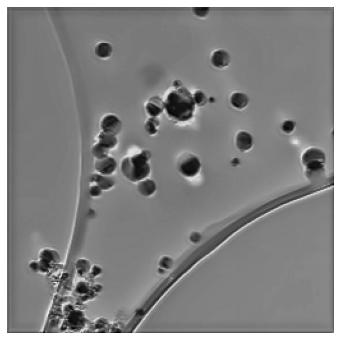

In [16]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Load a pre-trained model from TensorFlow Hub
model = hub.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')

def enhance_image(image_path, save_path):
    pil_image = Image.open(image_path).convert('L')
    original_size = pil_image.size  
    image = np.array(pil_image)
    rgb_image = np.stack((image,) * 3, axis=-1)
    
    # Convert to TensorFlow tensor and preprocess
    rgb_image = tf.cast(rgb_image, tf.float32) / 255.0
    rgb_image = tf.expand_dims(rgb_image, 0)

    # Apply the model
    enhanced_image = model(rgb_image)
    enhanced_image = tf.squeeze(enhanced_image, 0)

    # Resize to original dimensions
    resized_enhanced_image = tf.image.resize(enhanced_image, original_size, method=tf.image.ResizeMethod.BICUBIC)

    # Convert the output back to grayscale
    grayscale_output = tf.image.rgb_to_grayscale(resized_enhanced_image)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_image = tf.keras.preprocessing.image.array_to_img(grayscale_output)
    save_image.save(save_path)

    return grayscale_output

image_path = 'Datasets/RGB/Dataset_4/Janustomo2_-1.04.jpg'  
save_path = 'Output/Output_29/enhanced_image.jpg'  
enhanced_image = enhance_image(image_path, save_path)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(enhanced_image.numpy().squeeze(), cmap='gray')  
plt.axis('off')
plt.show()


PSNR Check between the two images

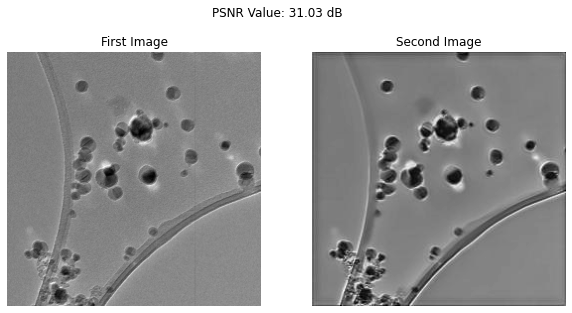

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_psnr(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def show_images_with_psnr(image_path1, image_path2):
    img1 = load_image(image_path1)
    img2 = load_image(image_path2)

    psnr_value = calculate_psnr(img1, img2)

    plt.figure(figsize=(10, 5))

    # Display first image
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('First Image')
    plt.axis('off')

    # Display second image
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title('Second Image')
    plt.axis('off')

    plt.suptitle(f"PSNR Value: {psnr_value:.2f} dB")
    plt.show()


image_path1 = 'Datasets/BMP/Dataset_4/Janustomo2_-1.04.bmp'
image_path2 = 'Output/Output_29/enhanced_image.jpg'

show_images_with_psnr(image_path1, image_path2)


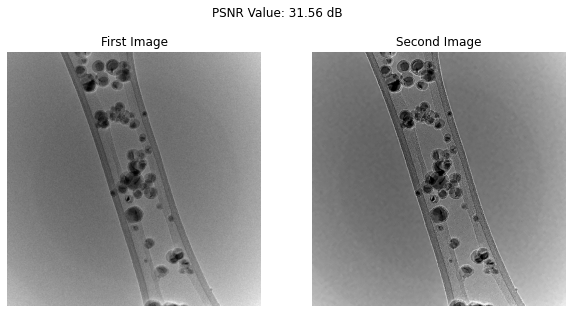

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_psnr(image1, image2):
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def load_image(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def show_images_with_psnr(image_path1, image_path2):
    img1 = load_image(image_path1)
    img2 = load_image(image_path2)

    psnr_value = calculate_psnr(img1, img2)

    plt.figure(figsize=(10, 5))

    # Display first image
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title('First Image')
    plt.axis('off')

    # Display second image
    plt.subplot(1, 2, 2) # 1 row, 2 cols, index 2
    plt.imshow(img2, cmap='gray') 
    plt.title('Second Image')
    plt.axis('off')

    plt.suptitle(f"PSNR Value: {psnr_value:.2f} dB")
    plt.show()


image_path1 = 'Datasets/JPG/Dataset_7/2725_-4_Rio16_40kX_0174.jpg'
image_path2 = 'Output/Output_28_Dataset_3/frames/frames_output_enhancer/frame_0.jpg'

show_images_with_psnr(image_path1, image_path2)
